In [48]:
%load_ext autoreload
%autoreload 2

import casadi as ca
import matplotlib.pyplot as plt 
from autodiff_sys import Sys
from helper_fns import *
k0 = ca.MX.sym('k0')
m1 = ca.MX.sym('m1')
b1 = ca.MX.sym('b1')
k1 = ca.MX.sym('k1')
m2 = ca.MX.sym('m2')
b2 = ca.MX.sym('b2')
k2 = ca.MX.sym('k2')
p = [k0, m1, b1, k1, m2, b2, k2]
Gk0 = Sys([k0],[1])
Gm1 = Sys([1],[m1, 0, 0])
Gbk1 = Sys([b1, k1], [1])
Gk1 = Sys([k1],[1])
Gm2 = Sys([1],[m2, 0, 0])
Gbk2 = Sys([b2, k2], [1])
Gmbk2 = Gm2/(1+Gm2*Gbk2)
Gmbk2bk1 = Gbk1/(1+Gbk1*Gmbk2)
G_x_to_f = Gk1/(1+Gk1*Gmbk2)
G_u_to_x = Gm2/(1+Gm2*Gmbk2bk1)
G_x_to_f2 = Gk0/(1+Gk0*G_u_to_x)

print(G_x_to_f)
A, B, C = tf2ss(G_x_to_f.num, G_x_to_f.den)
print(A)
print(B)
print(C)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
num: [MX((k1*sq(m2))), MX((k1*(m2*b2))), MX((k1*(m2*k2))), MX(0), MX(0)] den: [MX(sq(m2)), MX((m2*b2)), MX(((m2*k2)+(k1*m2))), MX(0), MX(0)]
Cancelling pole/zero at 0
Cancelling pole/zero at 0
@1=sq(m2), ((horzcat(horzcat(0, 1)', zeros(2x1))'[1] = (-(((m2*k2)+(k1*m2))/@1)))[3] = (-((m2*b2)/@1)))
(zeros(2x1)[1] = 1)
@1=sq(m2), ((zeros(1x2)[0] = ((k1*(m2*k2))/@1))[1] = ((k1*(m2*b2))/@1))


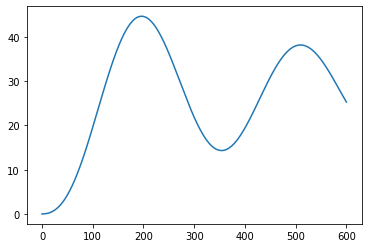

In [50]:
p0 = [10, 5, 10, 2000, 10, 20, 10]
u = x#[2]*1000
x0 = ca.MX.zeros(4,1)
y = G_x_to_f2.simulate(u, x0, dt=0.001)

y_eval = ca.Function('y_eval', p,y)
y_num = y_eval(*p0)
plt.figure()
plt.plot(y_num)
plt.show()

In [3]:
import csv
def import_csv(name):
    with open(name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        f = []
        x = []
        for row in csv_reader:
            x.append(float(row[0]))
            f.append(float(row[1]))
    return x,f

0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        7
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        7
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0

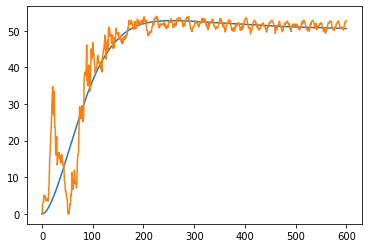

In [52]:
x0 = ca.MX.zeros(4,1)
p0 = [10, 5, 10, 10, 5, 150, 20]
x,f = import_csv('data/yellow_feet_coll.csv')
u = x
y = G_x_to_f2.simulate(u, x0, dt=0.001)
print(y[0])
ym = f
nlp = {'x':ca.vertcat(*p), 'f':ca.sumsqr(ca.vertcat(*y)-ym)}
solver = ca.nlpsol('solver','ipopt',nlp)
soln = solver(x0 = p0, lbx = 0.1, ubx = 1e10)
print(soln['x'])
y_num = y_eval(*ca.vertsplit(soln['x']))
plt.figure()
plt.plot(y_num, label='Fit model')
plt.plot(ym, label='Data')
plt.show()